In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import sys

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the scripts directory, download it from GitHub if it doesn't work
try:
    from scripts import data_setup, engine
    from scripts.helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find scripts or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/radoslaw626/TinyVGG
    !move TinyVGG/scripts .
    !rd /s /q TinyVGG
    sys.path.append('scripts')
    from scripts import data_setup, engine
    from scripts.helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

In [4]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [5]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnetb2_transforms = effnetb2_weights.transforms()

effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)


for param in effnetb2.parameters():
    param.requires_grad = False


In [7]:
from torchinfo import summary

summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [10]:
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [11]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes))
    
    return model, transforms

In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [13]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [15]:
from scripts import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 test_transform=effnetb2_transforms,
                                                                                                 train_transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [16]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), len(class_names)

(15, 5, 3)

In [17]:
from scripts import engine

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9843 | train_acc: 0.5667 | test_loss: 0.7410 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7171 | train_acc: 0.8396 | test_loss: 0.5877 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5878 | train_acc: 0.8938 | test_loss: 0.4901 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4481 | train_acc: 0.9125 | test_loss: 0.4349 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4302 | train_acc: 0.9062 | test_loss: 0.3921 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4400 | train_acc: 0.8875 | test_loss: 0.3522 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.4253 | train_acc: 0.8792 | test_loss: 0.3267 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3900 | train_acc: 0.8979 | test_loss: 0.3461 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3769 | train_acc: 0.8771 | test_loss: 0.3130 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3769 | train_acc: 0.8625 | test_loss: 0.2814 | test_acc: 0.9688


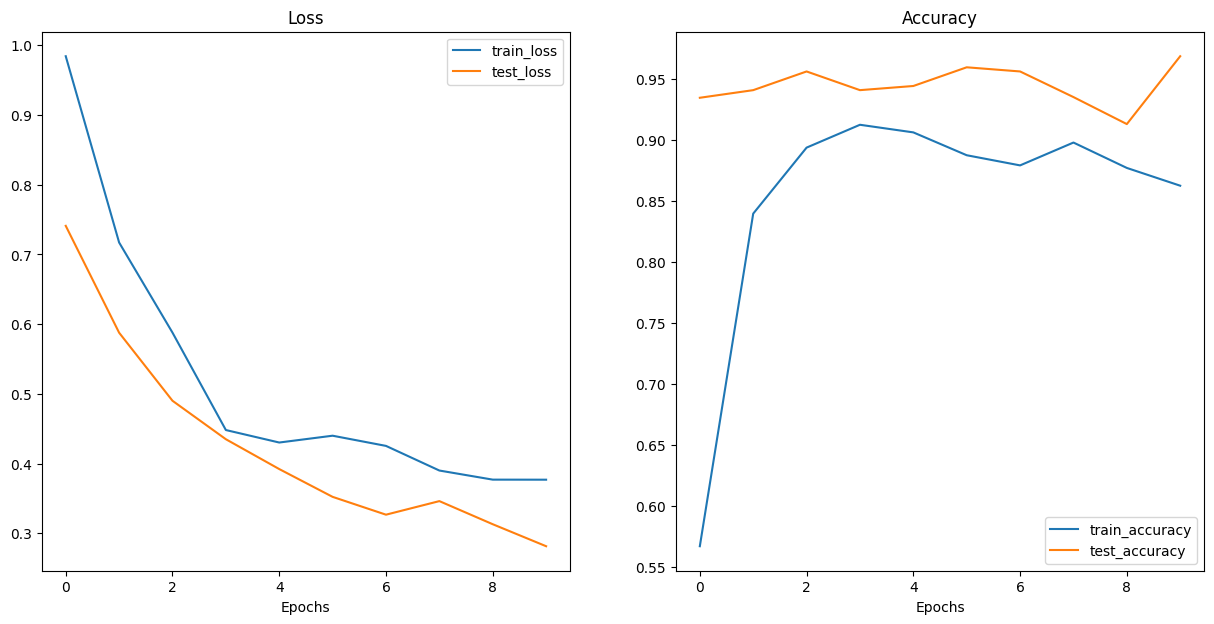

In [18]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [19]:
from scripts import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [20]:
from pathlib import Path

pretrained_effnetb2_model_size = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)

print(f"{round(pretrained_effnetb2_model_size, 2)} MB")

29.86 MB


In [21]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size [MB]": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28143160343170165,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size [MB]': 29.8624210357666}

In [23]:
vit = torchvision.models.vit_b_16()

vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [24]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    for param in model.parameters():
        param.requires_grad=False
    
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=768, bias=True))

    return model, transforms

In [25]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [26]:
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

C:\Users\mical\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 768]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [27]:
from scripts import data_setup

train_dataloader_vit,  test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=vit_transforms,
                                                                                        test_transform=vit_transforms,
                                                                                        batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [28]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.1027 | train_acc: 0.6167 | test_loss: 1.5051 | test_acc: 0.8528
Epoch: 2 | train_loss: 0.8269 | train_acc: 0.8938 | test_loss: 0.3259 | test_acc: 0.9540
Epoch: 3 | train_loss: 0.3291 | train_acc: 0.9417 | test_loss: 0.1883 | test_acc: 0.9631
Epoch: 4 | train_loss: 0.2242 | train_acc: 0.9563 | test_loss: 0.1480 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.2077 | train_acc: 0.9604 | test_loss: 0.1287 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.2047 | train_acc: 0.9313 | test_loss: 0.1119 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.1461 | train_acc: 0.9625 | test_loss: 0.1107 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.1500 | train_acc: 0.9750 | test_loss: 0.0972 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.1421 | train_acc: 0.9771 | test_loss: 0.0919 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.1272 | train_acc: 0.9771 | test_loss: 0.0810 | test_acc: 0.9784


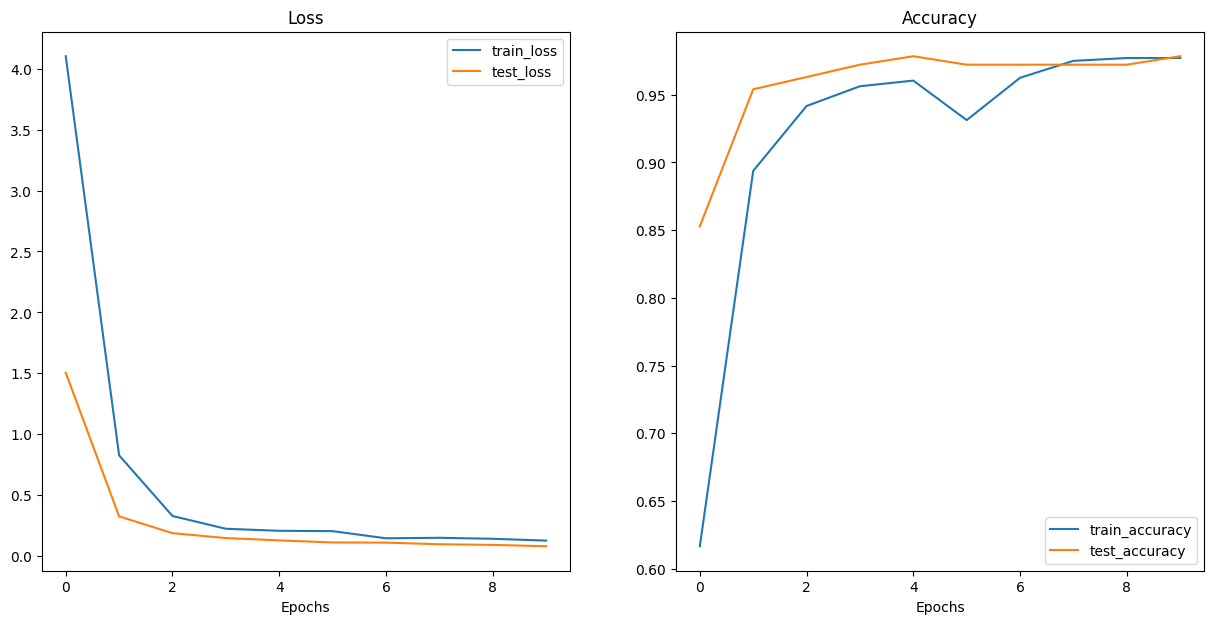

In [29]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [30]:
from scripts import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [31]:
from pathlib import Path

pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)

print(f"{round(pretrained_vit_model_size, 2)} MB")


329.61 MB


In [32]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

86389248

In [33]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size [MB]": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.08097900766879321,
 'test_acc': 0.978409090909091,
 'number_of_parameters': 86389248,
 'model_size [MB]': 329.61460304260254}

In [34]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

In [35]:
import pathlib
import torch

from PIL import Image
from typing import List, Dict
from timeit import default_timer as timer
from tqdm.auto import tqdm


def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    pred_list = []
    
    for path in tqdm(paths):
        pred_dict = {}

        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()

        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(0).to(device)

        model=model.to(device)
        model.eval()

        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            end_time = timer()

            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        pred_dict["correct"] = class_name == pred_class
        pred_list.append(pred_dict)

    return pred_list

        


In [36]:
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")


  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9939,
  'pred_class': 'pizza',
  'time_for_pred': 0.1443,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4828,
  'pred_class': 'pizza',
  'time_for_pred': 0.0778,
  'correct': True}]

In [38]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9939,pizza,0.1443,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4828,pizza,0.0778,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9921,pizza,0.0777,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6961,pizza,0.0763,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7656,pizza,0.0825,True


In [39]:
effnetb2_test_pred_df.correct.value_counts()

correct
True     145
False      5
Name: count, dtype: int64

In [40]:
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"avg time per pred: {effnetb2_average_time_per_pred}")



avg time per pred: 0.076


In [41]:
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred 
effnetb2_stats

{'test_loss': 0.28143160343170165,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size [MB]': 29.8624210357666,
 'time_per_pred_cpu': 0.076}

In [42]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [43]:
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9903,
  'pred_class': 'pizza',
  'time_for_pred': 0.2664,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9938,
  'pred_class': 'pizza',
  'time_for_pred': 0.1014,
  'correct': True}]

In [44]:
import pandas as pd
vit_test_pred_dicts_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_dicts_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9903,pizza,0.2664,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9938,pizza,0.1014,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9921,pizza,0.1030,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9938,pizza,0.1027,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9797,pizza,0.1107,True


In [45]:
vit_test_pred_dicts_df.correct.value_counts()

correct
True     147
False      3
Name: count, dtype: int64

In [46]:
vit_avarage_time_per_pred = round(vit_test_pred_dicts_df.time_for_pred.mean(), 4)
print(f"avg time per pred: {vit_avarage_time_per_pred}")

avg time per pred: 0.1039


In [47]:
vit_stats["time_per_pred_cpu"] = vit_avarage_time_per_pred
vit_stats

{'test_loss': 0.08097900766879321,
 'test_acc': 0.978409090909091,
 'number_of_parameters': 86389248,
 'model_size [MB]': 329.61460304260254,
 'time_per_pred_cpu': 0.1039}

In [48]:
df = pd.DataFrame([effnetb2_stats, vit_stats])

df["model"] = ["EffNetB2", "ViT"]

df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size [MB],time_per_pred_cpu,model
0,0.281432,96.88,7705221,29.862421,0.0760,EffNetB2
1,0.080979,97.84,86389248,329.614603,0.1039,ViT


In [49]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size [MB],time_per_pred_cpu
ViT to EffNetB2 ratios,0.28774,1.009909,11.211781,11.037772,1.367105


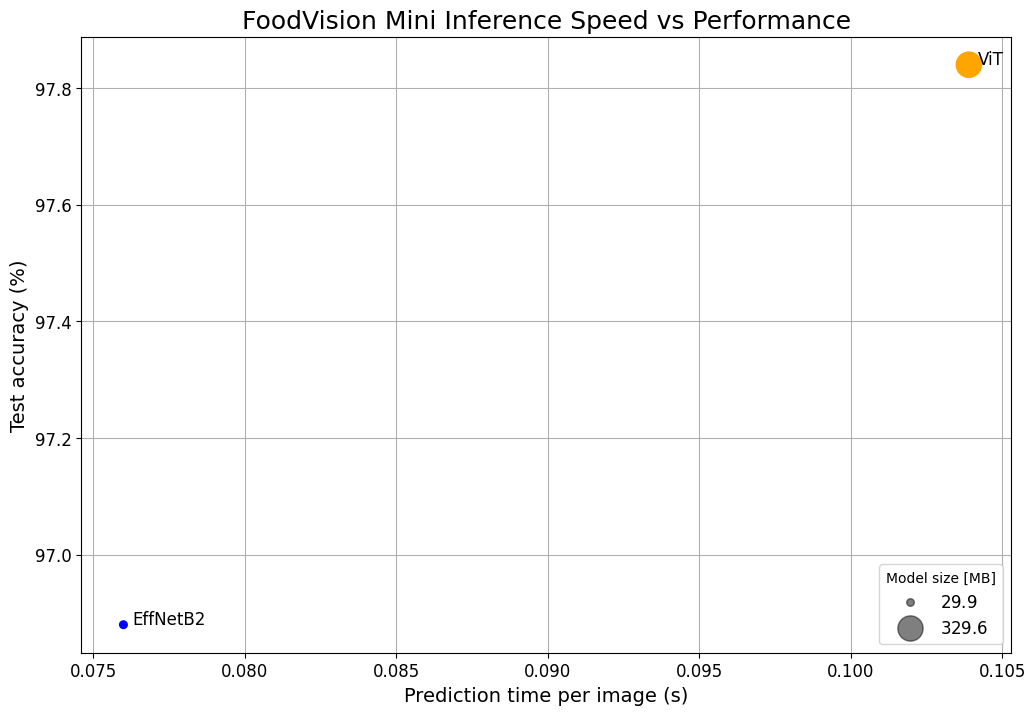

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size [MB]")

ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (s)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0003, row["test_acc"]),
                size=12)
    
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size [MB]",
                              fontsize=12)

plt.savefig("foodvision_inference_vs_speed.png")


In [51]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [52]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    end_time = timer()

    pred_time = round(end_time - start_time, 4)



    return pred_labels_and_probs, pred_time

In [53]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path} \n")

pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data\pizza_steak_sushi_20_percent\test\pizza\1001116.jpg
[INFO] Predicting on image at path: data\pizza_steak_sushi_20_percent\test\pizza\380739.jpg 

{'pizza': 0.9422721266746521, 'steak': 0.019907601177692413, 'sushi': 0.037820253521203995}
0.077


In [54]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\pizza\\3376617.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\413497.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\1245545.jpg']]

In [55]:
random.sample(test_data_paths, k=3)

[WindowsPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/sushi/301603.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/sushi/167716.jpg')]

In [56]:
import gradio as gr

title = "Foodvision Mini"
description = "An EffiecientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi"
article = "Created for model deployment learning"

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

demo.launch(debug=True,
            share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://4d71869319391623e7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4d71869319391623e7.gradio.live


In [64]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path("demos/foodvision_mini/")

if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

!dir demos\foodvision_mini\


 Volume in drive C has no label.
 Volume Serial Number is CA98-1463

 Directory of c:\Users\mical\Desktop\Jupyter Notebooks\model_deployment\demos\foodvision_mini

24/07/2024  14:14    <DIR>          .
24/07/2024  14:14    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)  485,154,119,680 bytes free


In [66]:
import shutil
from pathlib import Path

foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True,
                                    exist_ok=True)

foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


In [67]:
import os

example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

In [70]:
import shutil
effnetb2_foodvision_mini_model_path = "models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

try:
    print(f"[INFO] Atttempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)
    print(f"Model moved succesfully")

except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")



[INFO] Atttempting to move models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos\foodvision_mini\pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] No model found at models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model exists at demos\foodvision_mini\pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth: True
